In [1]:
from utils import *
from scipy.stats import qmc
from scipy.stats import spearmanr
from scipy import optimize
import os
import pandas as pd

In [2]:
lh = qmc.LatinHypercube(1, seed=23548709)
def sample(low, high, n):
    smpl = lh.random(n)
    smpl = qmc.scale(smpl, low, high)
    smpl = np.sort(smpl.ravel())
    return smpl

In [3]:
def g(ell, gp, mean_ntk, data):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})


    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])
    
    return np.sqrt(np.mean((mean_ntk - mean)**2))

In [31]:
depths=(3,25,100)
arrays = [
    ['Ackley', 'Franke', 'Nonpoly'],
    # [False, True],  # Norm
    [False, True],  # Noise
    # depths,
    # ['fixed', 'unfixed']
]

index = pd.MultiIndex.from_product(
    arrays, names=["Dataset", "Noise"])


df_gaus_rd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_gaus_sd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_lap_rd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_lap_sd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_gaus_rd

D3rmse D25rmse D100rmse D3corr D25corr D100corr
Dataset Noise                                                
Ackley  False    NaN     NaN      NaN    NaN     NaN      NaN
        True     NaN     NaN      NaN    NaN     NaN      NaN
Franke  False    NaN     NaN      NaN    NaN     NaN      NaN
        True     NaN     NaN      NaN    NaN     NaN      NaN
Nonpoly False    NaN     NaN      NaN    NaN     NaN      NaN
        True     NaN     NaN      NaN    NaN     NaN      NaN

In [4]:
arrsize=20
norm = False
noisy = False

if noisy:
    noise = 0.3

datasets=[]

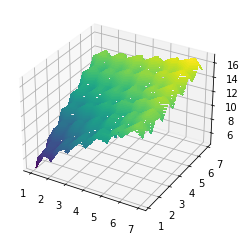

In [20]:
# Ackley's function
tmp1 = sample(1,7, arrsize)
tmp2 = sample(1,7, arrsize)
tmp3 = sample(1,7, arrsize)
tmp4 = sample(1,7, arrsize)
X1, Y1 = np.meshgrid(tmp1, tmp2)    
Z1 = -20*np.exp(-0.2 * np.sqrt(0.5*(X1**2 + Y1**2))) - np.exp(0.5 *(np.cos(2*np.pi*X1) + np.cos(2*np.pi*Y1))) + np.e + 20
X2, Y2 = np.meshgrid(tmp3, tmp4)    
Z2 = -20*np.exp(-0.2 * np.sqrt(0.5*(X2**2 + Y2**2))) - np.exp(0.5 *(np.cos(2*np.pi*X2) + np.cos(2*np.pi*Y2))) + np.e + 20

bigX1 = np.stack((X1,Y1), axis=2).reshape(-1,2)
smolY1 = Z1.reshape(-1,1)
bigX2 = np.stack((X2,Y2), axis=2).reshape(-1,2)
smolY2 = Z2.reshape(-1,1)

if norm:
    X_train = normalize(bigX1, axis=1)
    X_test = normalize(bigX2, axis=1)
    X_draw = bigX2
else:
    X_train = bigX1
    X_test = bigX2
    X_draw = bigX2

if noise == 0.0:
    y_train = smolY1
    y_test = smolY2
else:
    y_train = np.random.normal(smolY1, scale = noise)
    y_test = np.random.normal(smolY2, scale = noise)

ax = plt.subplot(projection='3d')
ax.contourf(X1,Y1,Z1, levels=100)
datasets.append([X_train, y_train, X_test, y_test, 'Ackley'])

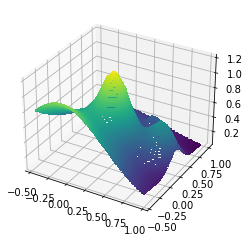

In [18]:
# Franke's function
tmp1 = sample(-0.5,1, arrsize)
tmp2 = sample(-0.5,1, arrsize)
tmp3 = sample(-0.5,1, arrsize)
tmp4 = sample(-0.5,1, arrsize)
X1, Y1 = np.meshgrid(tmp1, tmp2)     
Z1 = (0.75*np.exp(- (9*X1 - 2)**2/4 - (9*Y1 - 2)**2/4) + 
        0.75*np.exp(- (9*X1 + 1)**2/49 - (9*Y1 + 1)/10) +
        0.5*np.exp(- (9*X1 - 7)**2/4  - (9*Y1 - 3)**2/4) +
        0.2*np.exp(- (9*X1 - 4)**2    - (9*Y1 - 7)**2))
X2, Y2 = np.meshgrid(tmp3, tmp4)     
Z2 = (0.75*np.exp(- (9*X2 - 2)**2/4 - (9*Y2 - 2)**2/4) + 
        0.75*np.exp(- (9*X2 + 1)**2/49 - (9*Y2 + 1)/10) +
        0.5*np.exp(- (9*X2 - 7)**2/4  - (9*Y2 - 3)**2/4) +
        0.2*np.exp(- (9*X2 - 4)**2    - (9*Y2 - 7)**2))

if norm:
    X_train = normalize(bigX1, axis=1)
    X_test = normalize(bigX2, axis=1)
    X_draw = bigX2
else:
    X_train = bigX1
    X_test = bigX2
    X_draw = bigX2

if noise == 0.0:
    y_train = smolY1
    y_test = smolY2
else:
    y_train = np.random.normal(smolY1, scale = noise)
    y_test = np.random.normal(smolY2, scale = noise)


ax = plt.subplot(projection='3d')
ax.contourf(X1,Y1,Z1, levels=100)
datasets.append([X_train, y_train, X_test, y_test, 'Franke'])

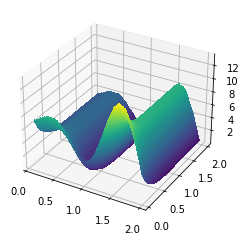

In [22]:
# Lim et al. nonpolynomial function
tmp1 = sample(0,2, arrsize)
tmp2 = sample(0,2, arrsize)
tmp3 = sample(0,2, arrsize)
tmp4 = sample(0,2, arrsize)
X1, Y1 = np.meshgrid(tmp1, tmp2)   
Z1 = 1/6 * ((30+5*X1*np.sin(5*X1))*(4+np.exp(-5*Y1)) - 100)
X2, Y2 = np.meshgrid(tmp3, tmp4)   
Z2 = 1/6 * ((30+5*X2*np.sin(5*X2))*(4+np.exp(-5*Y2)) - 100)

if norm:
    X_train = normalize(bigX1, axis=1)
    X_test = normalize(bigX2, axis=1)
    X_draw = bigX2
else:
    X_train = bigX1
    X_test = bigX2
    X_draw = bigX2

if noise == 0.0:
    y_train = smolY1
    y_test = smolY2
else:
    y_train = np.random.normal(smolY1, scale = noise)
    y_test = np.random.normal(smolY2, scale = noise)

ax = plt.subplot(projection='3d')
ax.contourf(X1,Y1,Z1, levels=100)
datasets.append([X_train, y_train, X_test, y_test, 'Nonpoly'])

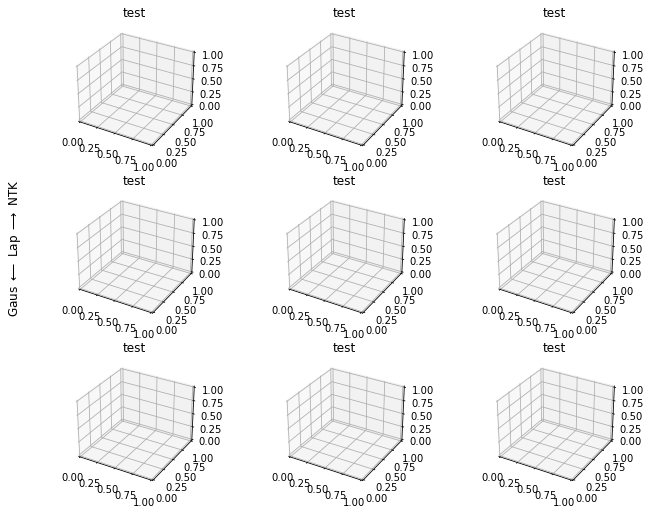

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(10,7))
axes = axes.ravel()
for i in range(0,9):
    axes[i].remove()
    axes[i] = plt.subplot(3,3,i + 1, projection='3d')
    axes[i].patch.set_alpha(0)
    axes[i].set_title('test')

fig.supylabel(r'Gaus $\longleftarrow$ Lap $\longrightarrow$ NTK', x=0.05)
fig.tight_layout(h_pad=2)

In [29]:
%%capture

fig, axes = plt.subplots(3, 3, figsize=(10,8))
axes = axes.ravel()
for i in range(0,9):
    axes[i].remove()
    axes[i] = plt.subplot(3,3,i + 1, projection='3d')
    axes[i].patch.set_alpha(0)

fig1, axes1 = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
axes1 = axes1.ravel()

fig.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK', x=0.05)
fig1.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK', x=0.05)

for data in datasets:
    for j in range(0,3):
        if j == 0 : depth=3
        if j == 1 : depth=25
        if j == 2 : depth=100

        ntk = (
            ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
            NTK(depth=depth, c=2, bias=0.1, 
                bias_bounds=(1e-9, 1e5))
        )

        if noise:
            ntk += WhiteKernel(
                noise_level=0.15**2, 
                noise_level_bounds=(1e-4, 1e1)
            )

        gp_ntk = GPR(kernel=ntk, alpha=alpha, normalize_y=True,  n_restarts_optimizer=9, random_state=3480795)
        gp_ntk.fit(data[0], data[1])
        mean_ntk = gp_ntk.predict(data[2])

        print(gp_ntk.kernel_)

        if noise:
            const_val = gp_ntk.kernel_.get_params()['k1__k1__constant_value']
        else :
            const_val = gp_ntk.kernel_.get_params()['k1__constant_value']

        lpk = (
            ConstantKernel(
                constant_value=gp_ntk.kernel_.get_params()['k1__constant_value'],
                constant_value_bounds='fixed'
            ) *
            Matern(
                nu=1/2,
                # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
                length_scale=1,
                length_scale_bounds='fixed'
            ) 
            # + 
            # WhiteKernel(
            #     noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
            #     noise_level_bounds='fixed'
            # )
        )

        gp_lpk = GPR(kernel=lpk, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

        ell_lpk = optimize.minimize_scalar(g, args=(
            gp_lpk, mean_ntk, data), 
            method='bounded', bounds=[0.0001, 10], options={'maxiter': 10000})
        for i in range(-2, 6):
            tmp = optimize.minimize_scalar(g, args=(
                gp_lpk, mean_ntk, data),
                method='bounded', bounds=[0.0001, 10**i], options={'maxiter': 10000})
            if tmp.fun < ell_lpk.fun:
                ell_lpk = tmp

        try:
            gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
        except:
            gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
        gp_lpk.fit(data[0], data[1])
        mean_lpk_opt = gp_lpk.predict(data[2])

        print(gp_lpk.kernel_)


        rbf = (
            ConstantKernel(
                constant_value=1,
                constant_value_bounds=(1e-9, 1e5)
            ) *
                Matern(
                    nu=np.inf,
                    length_scale=1,
                    length_scale_bounds='fixed'
                )
            )

        gp_rbf = GPR(kernel=rbf, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)


        ell_rbf = optimize.minimize_scalar(g, args=(
            gp_rbf, mean_ntk, data), 
            method='bounded', bounds=[0.0001, 10], options={'maxiter': 10000})
        for i in range(-2, 6):
            tmp = optimize.minimize_scalar(g, args=(
                gp_rbf, mean_ntk, data),
                method='bounded', bounds=[0.0001, 10**i], options={'maxiter': 10000})
            if tmp.fun < ell_rbf.fun:
                ell_rbf = tmp

        try:
            gp_rbf.set_params(**{'kernel__k2__length_scale': ell_rbf.x})
        except:
            gp_rbf.set_params(**{'kernel__k1__k2__length_scale': ell_rbf.x})
        gp_rbf.fit(data[0], data[1])
        mean_rbf_opt = gp_rbf.predict(data[2])

        print(gp_rbf.kernel_)


        if norm:
            df_lap_sd[f'D{depth}rmse'][loc] = f'{ell_lpk.fun:.3e}'
            df_gaus_sd[f'D{depth}rmse'][loc] = f'{ell_gaus.fun:.3e}'
            df_lap_sd[f'D{depth}corr'][loc] = np.corrcoef((mean_ntk)[:,0], (mean_lpk_opt)[:,0])[0, 1]
            df_gaus_sd[f'D{depth}corr'][loc] = np.corrcoef((mean_ntk)[:,0], (mean_gaus_opt)[:,0])[0, 1]
        else:
            df_lap_rd[f'D{depth}rmse'][loc] = f'{ell_lpk.fun:.3e}'
            df_gaus_rd[f'D{depth}rmse'][loc] = f'{ell_gaus.fun:.3e}'
            df_lap_rd[f'D{depth}corr'][loc] = np.corrcoef((mean_ntk)[:,0], (mean_lpk_opt)[:,0])[0, 1]
            df_gaus_rd[f'D{depth}corr'][loc] = np.corrcoef((mean_ntk)[:,0], (mean_gaus_opt)[:,0])[0, 1]


        axes[j + 0].contourf(
            X_orig[:,0].reshape(-1, arrsize), 
            X_orig[:,1].reshape(-1, arrsize), 
            mean_ntk.reshape(-1, arrsize),
            levels=100)
        beta = gp_ntk.kernel_.get_params()['k2__bias']
        a,b = f'{beta:.3e}'.split('e')
        b = int(b)
        axes[j + 0].set_title(f'Depth = {depth}, ' + rf'$\beta = {a}\cdot 10^{{{b}}}$')

        axes[j + 3].contourf(
            X_orig[:,0].reshape(-1, arrsize), 
            X_orig[:,1].reshape(-1, arrsize), 
            mean_lpk_opt.reshape(-1, arrsize),
            levels=100)
        axes[j + 3].set_title(r'$\ell$ =' + f" {round(gp_lpk.kernel_.get_params()['k2__length_scale'], 4)}")

        axes[j + 6].contourf(
            X_orig[:,0].reshape(-1, arrsize), 
            X_orig[:,1].reshape(-1, arrsize), 
            mean_rbf_opt.reshape(-1, arrsize),
            levels=100)
        axes[j + 6].set_title(r'$\ell$ =' + f" {round(gp_rbf.kernel_.get_params()['k2__length_scale'], 4)}")


        axes1[j + 0].contourf(
            X_orig[:,0].reshape(-1, arrsize), 
            X_orig[:,1].reshape(-1, arrsize), 
            mean_ntk.reshape(-1, arrsize),
            levels=100)
        beta = gp_ntk.kernel_.get_params()['k2__bias']
        a,b = f'{beta:.3e}'.split('e')
        b = int(b)
        axes1[j + 0].set_title(f'Depth = {depth}, ' + rf'$\beta = {a}\cdot 10^{{{b}}}$')

        axes1[j + 3].contourf(
            X_orig[:,0].reshape(-1, arrsize), 
            X_orig[:,1].reshape(-1, arrsize), 
            mean_lpk_opt.reshape(-1, arrsize),
            levels=100)
        axes1[j + 3].set_title(r'$\ell$ =' + f" {round(gp_lpk.kernel_.get_params()['k2__length_scale'], 4)}")

        axes1[j + 6].contourf(
            X_orig[:,0].reshape(-1, arrsize), 
            X_orig[:,1].reshape(-1, arrsize), 
            mean_rbf_opt.reshape(-1, arrsize),
            levels=100)
        axes1[j + 6].set_title(r'$\ell$ =' + f" {round(gp_rbf.kernel_.get_params()['k2__length_scale'], 4)}")

    for a in axes1:
        a.set_yticks(a.get_xticks())
        a.set_xticks(a.get_xticks())
        a.set_aspect('equal', 'box')

In [30]:
print('RMSE', RMSE)
print('corr', corr)

RMSE [0.5171479728903663, 0.5830643873434781, 0.5090510747260621, 0.5898481078373019, 0.5087430103789031, 0.5897559415560991]
corr [0.9763166078704735, 0.9691942145205479, 0.9773994485017138, 0.9695442553263035, 0.9766520750400453, 0.9677469214490417]


In [ ]:
# Sd-1 data
# RMSE [6.560479311345243e-06, 1.9234107794845456, 0.0002988990322335508, 1.923647635078548, 0.004332489272917873, 1.9226963013453062]
# corr [0.9999999999967448, 0.35244313212874673, 0.9999999906357612, 0.35193680942107575, 0.9999979202436681, 0.3504706101841754]
# Rd data
# RMSE [0.5171479728903663, 0.5830643873434781, 0.5090510747260621, 0.5898481078373019, 0.5087430103789031, 0.5897559415560991]
# corr [0.9763166078704735, 0.9691942145205479, 0.9773994485017138, 0.9695442553263035, 0.9766520750400453, 0.9677469214490417]

In [33]:
fig.tight_layout()
fig.savefig('./ackleyNoNormNoNoise3D.png', dpi=200)
fig.savefig('./ackleyNoNormNoNoise3D.svg')
fig1.tight_layout()
fig1.savefig('./ackleyNoNormNoNoise2D.png', dpi=200)
fig1.savefig('./ackleyNoNormNoNoise2D.svg')

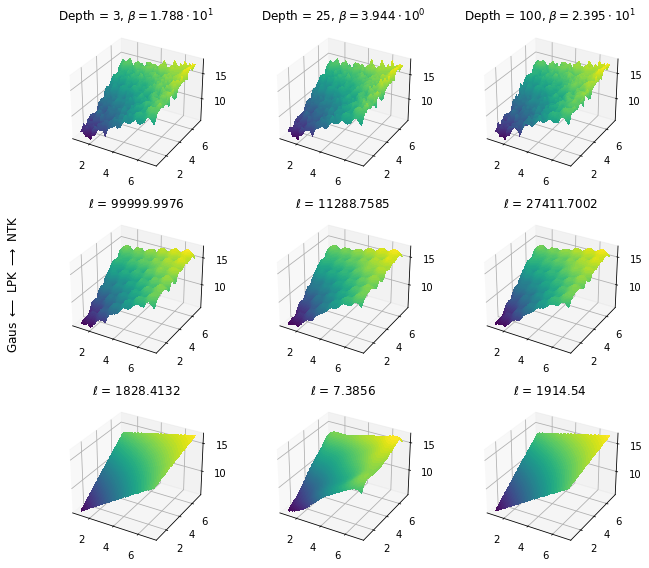

In [32]:
fig.tight_layout()
fig

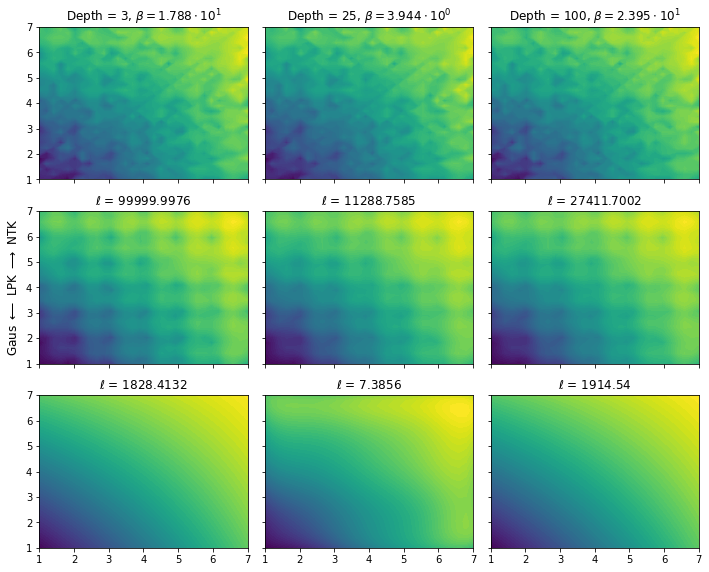

In [34]:
fig1.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK')
fig1.tight_layout()
fig1

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


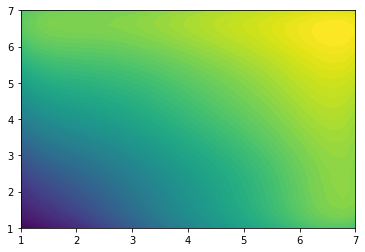

In [43]:
rbf = (
    ConstantKernel(
        constant_value=1,
        constant_value_bounds=(1e-9, 1e5)
    ) *
        Matern(
            nu=np.inf,
            length_scale=10,
            length_scale_bounds='fixed'
        )
    )

gp_rbf = GPR(kernel=rbf, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

gp_rbf.fit(X_train, y_train)
test = gp_rbf.predict(X_orig)

plt.contourf(X_orig[:,0].reshape(-1, arrsize), X_orig[:,1].reshape(-1, arrsize), test.reshape(-1, arrsize), levels=100)

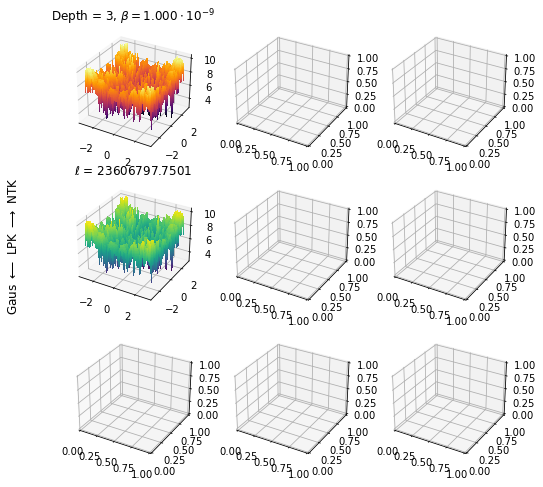

In [27]:
fig